# LOAD DATA

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_csv=pd.read_csv('./online_retail_II_Germany_preprocessed.csv')

In [3]:
df_csv.describe()

,Invoice,Quantity,Price,Customer ID
count,8346.000000,8346.000000,8346.000000,8346.000000
mean,559819.372634,13.523544,2.757295,12647.977235
std,12644.973883,15.686804,3.104513,312.044961
min,536527.000000,1.000000,0.040000,12426.000000
25%,549316.000000,6.000000,1.250000,12480.000000
50%,560728.000000,12.000000,1.650000,12600.000000
75%,570640.000000,12.000000,2.950000,12662.000000
max,581578.000000,198.500000,44.685000,14335.000000


In [4]:
print(df_csv.dtypes)

Invoice          int64
StockCode       object
Description     object
Quantity       float64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object


In [5]:
from sklearn.preprocessing import OrdinalEncoder

In [6]:
encoder=OrdinalEncoder(dtype='int')
df_csv[['StockCode']]=encoder.fit_transform(df_csv[['StockCode']])

In [7]:
df = df_csv.sample(frac=0.5, random_state=1)
print(df)

      Invoice  StockCode                          Description  Quantity  \
4152   560635       1143               JUMBO BAG VINTAGE LEAF      10.0   
4080   560590       1203    SET OF 12 FAIRY CAKE BAKING CASES       8.0   
1063   542369        549           3 HOOK HANGER MAGIC GARDEN      12.0   
5020   564856       1369           BLACK CHRISTMAS TREE 120CM      12.0   
6016   569844        186                GREEN POLKADOT PLATE       24.0   
...       ...        ...                                  ...       ...   
8060   579901        443   MINI CAKE STAND  HANGING STRAWBERY       8.0   
4887   564216       1203    SET OF 12 FAIRY CAKE BAKING CASES       8.0   
236    538174        805         STRAWBERRY FAIRY CAKE TEAPOT       8.0   
7860   578472       1250      SET 36 COLOUR PENCILS SPACEBOY       16.0   
7423   576630       1469  CHARLIE + LOLA RED HOT WATER BOTTLE       6.0   

              InvoiceDate  Price  Customer ID  Country  
4152  2011-07-20 10:51:00   2.08      1252

In [8]:
print(df['Quantity'].sum())

55959.0


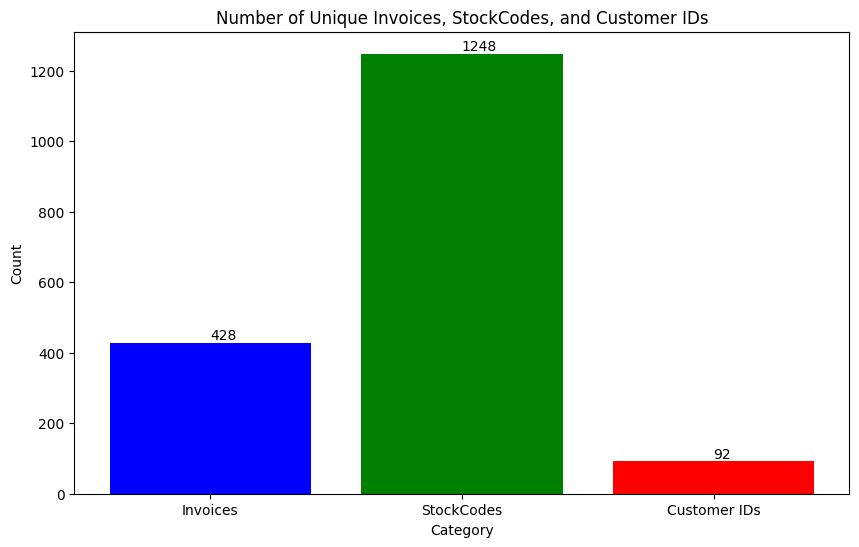

In [9]:
num_invoices = df['Invoice'].nunique()
num_stockcodes = df['StockCode'].nunique()
num_customers = df['Customer ID'].nunique()

import matplotlib.pyplot as plt

labels = ['Invoices', 'StockCodes', 'Customer IDs']
values = [num_invoices, num_stockcodes, num_customers]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['blue', 'green', 'red'])
plt.title('Number of Unique Invoices, StockCodes, and Customer IDs')
plt.xlabel('Category')
plt.ylabel('Count')

# Add the values on top of each bar
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

plt.show()

In [10]:
# determine the last purchase date (recency)
recency=df.groupby(by='Customer ID',as_index=False)['InvoiceDate'].max()
recency.columns=['Customer ID','Buy Date']
recency.head()

,Customer ID,Buy Date
0,12426.0,2011-05-29 12:26:00
1,12427.0,2011-11-18 08:56:00
2,12468.0,2011-06-05 11:36:00
3,12471.0,2011-12-07 15:43:00
4,12472.0,2011-11-07 14:01:00


In [11]:
# convert Buy Date from string to datetime
recency['Buy Date']=pd.to_datetime(recency['Buy Date'])

In [12]:
latest=pd.to_datetime(recency['Buy Date'].max())

In [13]:
# number of days since the last purchase (most recent date in the entire dataset) for each customer.
recency['Recency']=recency['Buy Date'].apply(lambda x: (latest-x).days)

In [14]:
recency

,Customer ID,Buy Date,Recency
0,12426.0,2011-05-29 12:26:00,193
1,12427.0,2011-11-18 08:56:00,21
2,12468.0,2011-06-05 11:36:00,187
3,12471.0,2011-12-07 15:43:00,1
4,12472.0,2011-11-07 14:01:00,31
...,...,...,...
87,13814.0,2011-09-08 13:48:00,91
88,13815.0,2011-11-17 14:19:00,21
89,13816.0,2011-11-16 08:38:00,23
90,13817.0,2011-11-10 17:49:00,28


In [15]:
# number of times the customer purchased products in the data.

frequency=df.groupby(by=['Customer ID'],as_index=False)['StockCode'].count()
frequency.columns=['Customer ID 3','Frequency']
frequency

,Customer ID 3,Frequency
0,12426.0,12
1,12427.0,12
2,12468.0,20
3,12471.0,208
4,12472.0,173
...,...,...
87,13814.0,23
88,13815.0,72
89,13816.0,11
90,13817.0,8


In [16]:
# monetary is a DataFrame containing information about the total spending of each customer.
df['TotalValue']=df['Quantity']*df['Price']
monetary=df.groupby(by=['Customer ID'],as_index=False).agg({'TotalValue': 'sum'})
monetary.columns=['Customer ID 2','Monetary']
monetary

,Customer ID 2,Monetary
0,12426.0,203.650
1,12427.0,296.845
2,12468.0,341.740
3,12471.0,8794.090
4,12472.0,3161.570
...,...,...
87,13814.0,610.350
88,13815.0,1725.105
89,13816.0,179.160
90,13817.0,125.020


In [17]:
# Combine the three DataFrames into one DataFrame called RFM.
RFM=pd.concat([recency,frequency,monetary],axis=1)
RFM=RFM.drop(columns=['Customer ID 2','Customer ID 3','Buy Date'])
RFM

,Customer ID,Recency,Frequency,Monetary
0,12426.0,193,12,203.650
1,12427.0,21,12,296.845
2,12468.0,187,20,341.740
3,12471.0,1,208,8794.090
4,12472.0,31,173,3161.570
...,...,...,...,...
87,13814.0,91,23,610.350
88,13815.0,21,72,1725.105
89,13816.0,23,11,179.160
90,13817.0,28,8,125.020


### Building RFM Segments

In [18]:
# classify customers into score groups based on three factors in RFM analysis
RFM['R']=pd.qcut(RFM['Recency'].rank(method='first'),5,labels=[5,4,3,2,1])
RFM['F']=pd.qcut(RFM['Frequency'].rank(method='first'),5,labels=[1,2,3,4,5])
RFM['M']=pd.qcut(RFM['Monetary'].rank(method='first'),5,labels=[1,2,3,4,5])

explaining how qcut() work?

In [19]:
RFM

,Customer ID,Recency,Frequency,Monetary,R,F,M
0,12426.0,193,12,203.650,1,2,2
1,12427.0,21,12,296.845,4,2,2
2,12468.0,187,20,341.740,1,3,3
3,12471.0,1,208,8794.090,5,5,5
4,12472.0,31,173,3161.570,3,5,5
...,...,...,...,...,...,...,...
87,13814.0,91,23,610.350,2,3,3
88,13815.0,21,72,1725.105,4,5,5
89,13816.0,23,11,179.160,4,2,1
90,13817.0,28,8,125.020,3,1,1


In [20]:
# Build RFM Segment and RFM Score
def add_rfm(x) : return str(x['R']) + str(x['F']) + str(x['M'])

RFM['RFM_Segment'] = RFM.apply(add_rfm, axis=1)

RFM['RFM_Score'] = RFM[['R', 'F', 'M']].sum(axis=1)

RFM.head()

,Customer ID,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
0,12426.0,193,12,203.650,1,2,2,1.02.02.0,5
1,12427.0,21,12,296.845,4,2,2,4.02.02.0,8
2,12468.0,187,20,341.740,1,3,3,1.03.03.0,7
3,12471.0,1,208,8794.090,5,5,5,5.05.05.0,15
4,12472.0,31,173,3161.570,3,5,5,3.05.05.0,13


- A higher total RFM score indicates a customer who is highly engaged: they bought recently, 
buy frequently, and spend a lot.
- A lower total RFM score indicates a customer who is less engaged: they haven't bought recently, 
buy infrequently, and spend less.

## Analyzing RFM Segments

In [21]:
RFM_Segment = RFM.groupby(['RFM_Segment']).size().sort_values(ascending=False)[:5]

print(RFM_Segment)

RFM_Segment
4.05.05.0    7
5.05.05.0    6
1.01.01.0    5
1.02.02.0    4
3.01.01.0    4
dtype: int64


Tại sao không phân khúc dựa trên RFM_Score?

- RFM_Score : 
    + chỉ đơn giản là cộng các điểm R, F, và M lại với nha
    + Không phản ánh đủ sự khác biệt giữa các khách hàng trong từng yếu tố riêng biệt (R, F, M).

- RFM_Segment: 
    + kết hợp ba giá trị R, F, và M thành một phân khúc duy nhất, ví dụ, '455' cho một khách hàng có R = 4, F = 5, M = 5.
    + giúp bạn hiểu rõ hơn về hành vi của khách hàng trong từng yếu tố riêng biệt.
    + Sử dụng RFM_Segment có thể tạo ra nhiều phân nhóm hơn. Mặc dù vậy, đây cũng là một cách để phân nhóm một cách chi tiết và rõ ràng.

- Sử dụng RFM_Segment: Thích hợp hơn khi bạn muốn phân nhóm khách hàng theo hành vi mua sắm cụ thể dựa trên từng yếu tố R, F, và M. Phương pháp này giúp bạn hiểu rõ hơn về hành vi của khách hàng trong các nhóm khác nhau.

## Summary metrics per RFM Score

In [22]:
RFM.groupby('RFM_Score').agg({'Recency': 'mean','Frequency': 'mean',

'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3           266.6       6.2     90.3     5
4           129.0       8.5    168.7     4
5           121.1       9.5    185.0    13
6            87.3      13.0    272.7     6
7            66.4      15.9    271.0     8
8            60.8      19.8    466.8     6
9           119.1      33.8    624.2     8
10           58.8      35.8   1074.3    10
11           19.2      39.2    859.6     6
12           19.7      72.7   1201.4     6
13           17.8      79.2   1892.4     4
14           15.1     115.1   2934.9    10
15            4.7     149.0   3966.0     6

### Use RFM score to group customers into gold, silver and bronze segments

count    92.000000
mean      9.000000
std       3.628338
min       3.000000
25%       6.000000
50%       9.000000
75%      12.000000
max      15.000000
Name: RFM_Score, dtype: float64


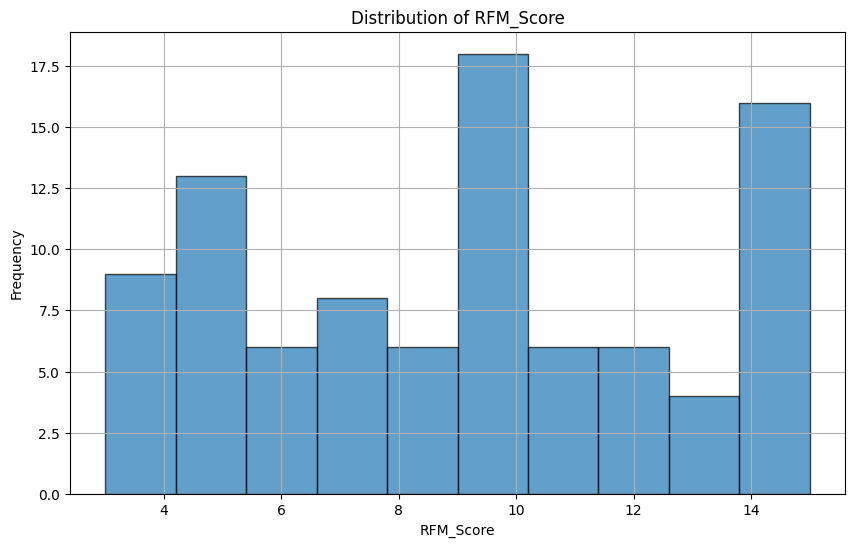

In [23]:
import matplotlib.pyplot as plt

# In mô tả phân phối của RFM_Score
print(RFM['RFM_Score'].describe())

# Vẽ histogram để trực quan hóa phân phối của RFM_Score
plt.figure(figsize=(10,6))
plt.hist(RFM['RFM_Score'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribution of RFM_Score')
plt.xlabel('RFM_Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [24]:
def segments(df):
  if df['RFM_Score'] > 12 :
    return 'Gold'
  elif (df['RFM_Score'] > 5) and (df['RFM_Score'] <= 12 ):
    return 'Silver'
  else:
    return 'Bronze'

RFM['General_Segment'] = RFM.apply(segments,axis=1)
RFM.groupby('General_Segment').agg({'Recency':'mean','Frequency':'mean',
'Monetary':['mean','count']}).round(1)

Recency Frequency Monetary      
                   mean      mean     mean count
General_Segment                                 
Bronze            155.6       8.5    160.5    22
Gold               12.5     118.1   3035.8    20
Silver             63.9      32.5    694.1    50

Merged rfm and main dataframe

In [25]:
mdf=pd.merge(df,RFM,on='Customer ID')

mdf

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalValue,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,General_Segment
0,560635,1143,JUMBO BAG VINTAGE LEAF,10.0,2011-07-20 10:51:00,2.08,12521.0,Germany,20.80,142,19,254.87,1,3,2,1.03.02.0,6,Silver
1,560590,1203,SET OF 12 FAIRY CAKE BAKING CASES,8.0,2011-07-19 15:55:00,0.83,12560.0,Germany,6.64,4,43,879.88,5,4,4,5.04.04.0,13,Gold
2,542369,549,3 HOOK HANGER MAGIC GARDEN,12.0,2011-01-27 13:08:00,1.95,12645.0,Germany,23.40,32,24,534.82,3,3,3,3.03.03.0,9,Silver
3,564856,1369,BLACK CHRISTMAS TREE 120CM,12.0,2011-08-31 09:11:00,7.25,12477.0,Germany,87.00,22,150,6210.20,4,5,5,4.05.05.0,14,Gold
4,569844,186,GREEN POLKADOT PLATE,24.0,2011-10-06 13:30:00,1.69,12626.0,Germany,40.56,22,153,3255.73,4,5,5,4.05.05.0,14,Gold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4168,579901,443,MINI CAKE STAND HANGING STRAWBERY,8.0,2011-12-01 08:35:00,1.65,12569.0,Germany,13.20,1,80,1562.61,5,5,4,5.05.04.0,14,Gold
4169,564216,1203,SET OF 12 FAIRY CAKE BAKING CASES,8.0,2011-08-24 09:23:00,0.83,12642.0,Germany,6.64,24,24,434.11,4,3,3,4.03.03.0,10,Silver
4170,538174,805,STRAWBERRY FAIRY CAKE TEAPOT,8.0,2010-12-10 09:35:00,4.95,12471.0,Germany,39.60,1,208,8794.09,5,5,5,5.05.05.0,15,Gold
4171,578472,1250,SET 36 COLOUR PENCILS SPACEBOY,16.0,2011-11-24 12:40:00,1.25,12476.0,Germany,20.00,14,105,2763.89,5,5,5,5.05.05.0,15,Gold


Created 3 data frames based on RFM segments to perform MBA.

In [26]:
Bronze_seg = mdf[mdf.General_Segment == 'Bronze']
Silver_seg = mdf[mdf.General_Segment == 'Silver']
Gold_seg = mdf[mdf.General_Segment == 'Gold']

In [27]:
print(Bronze_seg.describe())

             Invoice    StockCode    Quantity       Price   Customer ID  \
count     188.000000   188.000000  188.000000  188.000000    188.000000   
mean   556621.228723   662.441489   11.930851    3.153963  12680.643617   
std     11724.578662   461.252737   12.595327    4.216902    341.656871   
min    536840.000000     1.000000    1.000000    0.040000  12426.000000   
25%    545718.000000   189.500000    6.000000    0.850000  12559.000000   
50%    554985.000000   616.500000   10.000000    1.650000  12592.000000   
75%    569001.000000   994.500000   12.000000    3.750000  12648.000000   
max    575713.000000  1630.000000  108.000000   44.685000  13817.000000   

       TotalValue     Recency   Frequency    Monetary   RFM_Score  
count  188.000000  188.000000  188.000000  188.000000  188.000000  
mean    18.782952  154.925532    9.521277  171.261410    4.489362  
std     14.321100   97.039188    2.544697   69.178658    0.763396  
min      2.500000   28.000000    2.000000   65.10000

# Data Pre-Processing for K-means Clustering

Khi bạn thực hiện K-means, mô hình sẽ giả định rằng các biến đầu vào có cùng quy mô, tức là có trung bình và phương sai tương đương nhau, để đảm bảo rằng các biến sẽ đóng góp tương đương vào việc tính toán khoảng cách giữa các điểm dữ liệu. Nếu các biến có phương sai rất khác nhau, các biến có phương sai lớn sẽ có ảnh hưởng mạnh hơn trong việc phân cụm, điều này có thể làm giảm độ chính xác của mô hình.

In [28]:
rfm_rfm = RFM[['Recency','Frequency','Monetary']]
print(rfm_rfm.describe())

          Recency   Frequency     Monetary
count   92.000000   92.000000    92.000000
mean    74.641304   45.358696  1075.582446
std     88.411200   50.568978  1486.639587
min      0.000000    2.000000    59.870000
25%     15.000000   11.000000   199.687500
50%     30.000000   24.000000   489.560000
75%     91.000000   68.000000  1301.760000
max    371.000000  208.000000  8794.090000


In [29]:
from sklearn.preprocessing import StandardScaler

rfm_features = RFM[['Recency', 'Frequency', 'Monetary']]

# Standardize the features
scaler = StandardScaler() 
rfm_scaled = scaler.fit_transform(rfm_features)
rfm_rfm = pd.DataFrame(rfm_scaled, index=RFM.index, columns=rfm_features.columns)
rfm_rfm


,Recency,Frequency,Monetary
0,1.346065,-0.663282,-0.589726
1,-0.610050,-0.663282,-0.526694
2,1.277829,-0.504215,-0.496330
3,-0.837505,3.233850,5.220365
4,-0.496322,2.537934,1.410845
...,...,...,...
87,0.186044,-0.444565,-0.314657
88,-0.610050,0.529718,0.439301
89,-0.587304,-0.683165,-0.606290
90,-0.530440,-0.742815,-0.642907


# Plot the distribution of RFM values

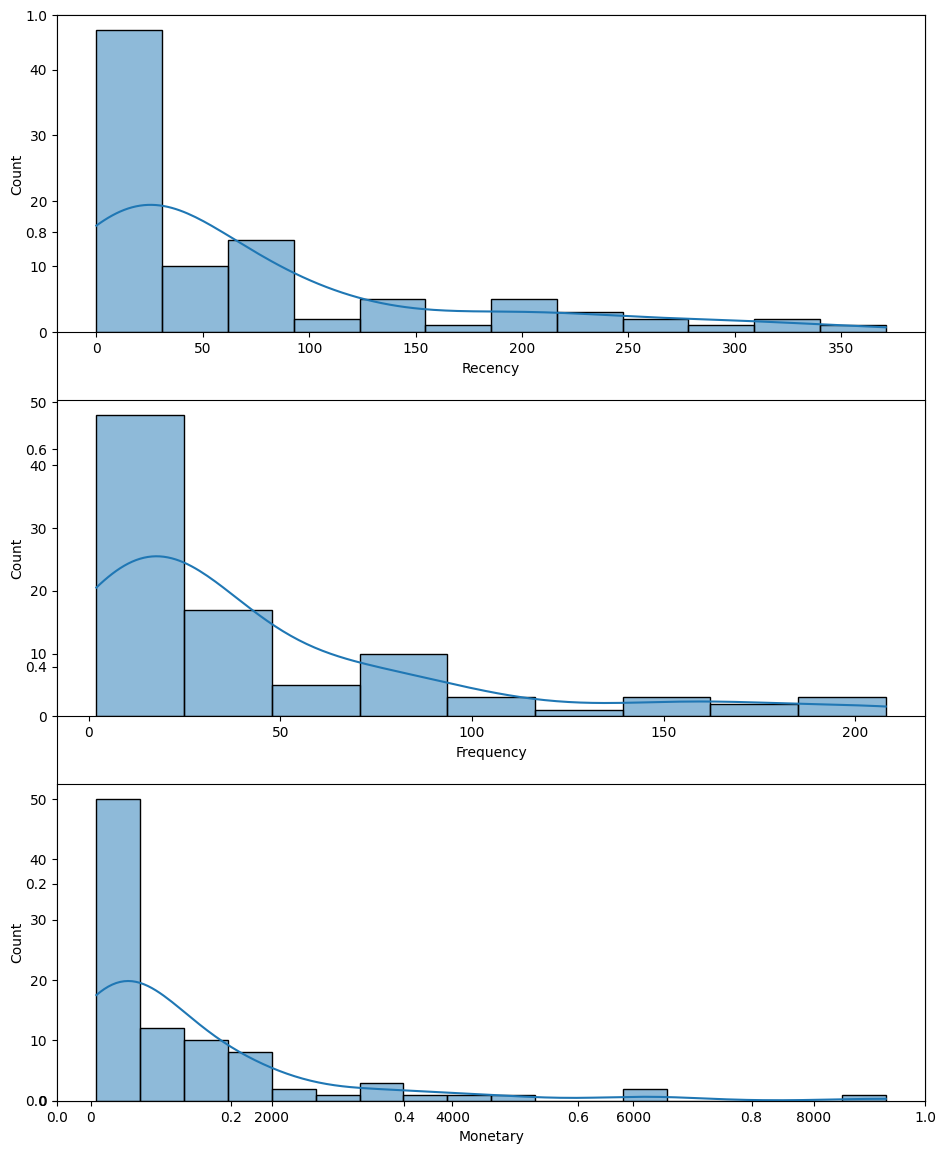

In [30]:
import seaborn as sns

f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.histplot(RFM.Recency, kde=True, label='Recency')
plt.subplot(3, 1, 2); sns.histplot(RFM.Frequency, kde=True, label='Frequency')
plt.subplot(3, 1, 3); sns.histplot(RFM.Monetary, kde=True, label='Monetary')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

- Nếu hầu hết dữ liệu nằm ở bên trái của biểu đồ nhưng một số giá trị lớn hơn nằm ở bên phải thì dữ liệu được cho là bị lệch sang bên phải.

- Xử lí : 
We use these Sequence of structuring pre-processing steps:

1. Unskew the data – log transformation

2. Standardize to the same average values

3. Scale to the same standard deviation

4. Store as a separate array to be used for clustering

Why the Sequence Matters?

  + Log transformation only works with positive data
  + Normalization forces data to have negative values and log will not work


### Unskew the data with log transformation

Các giá trị lớn sẽ bị giảm bớt, giúp phân phối của dữ liệu trở nên gần chuẩn hơn (normal distribution).

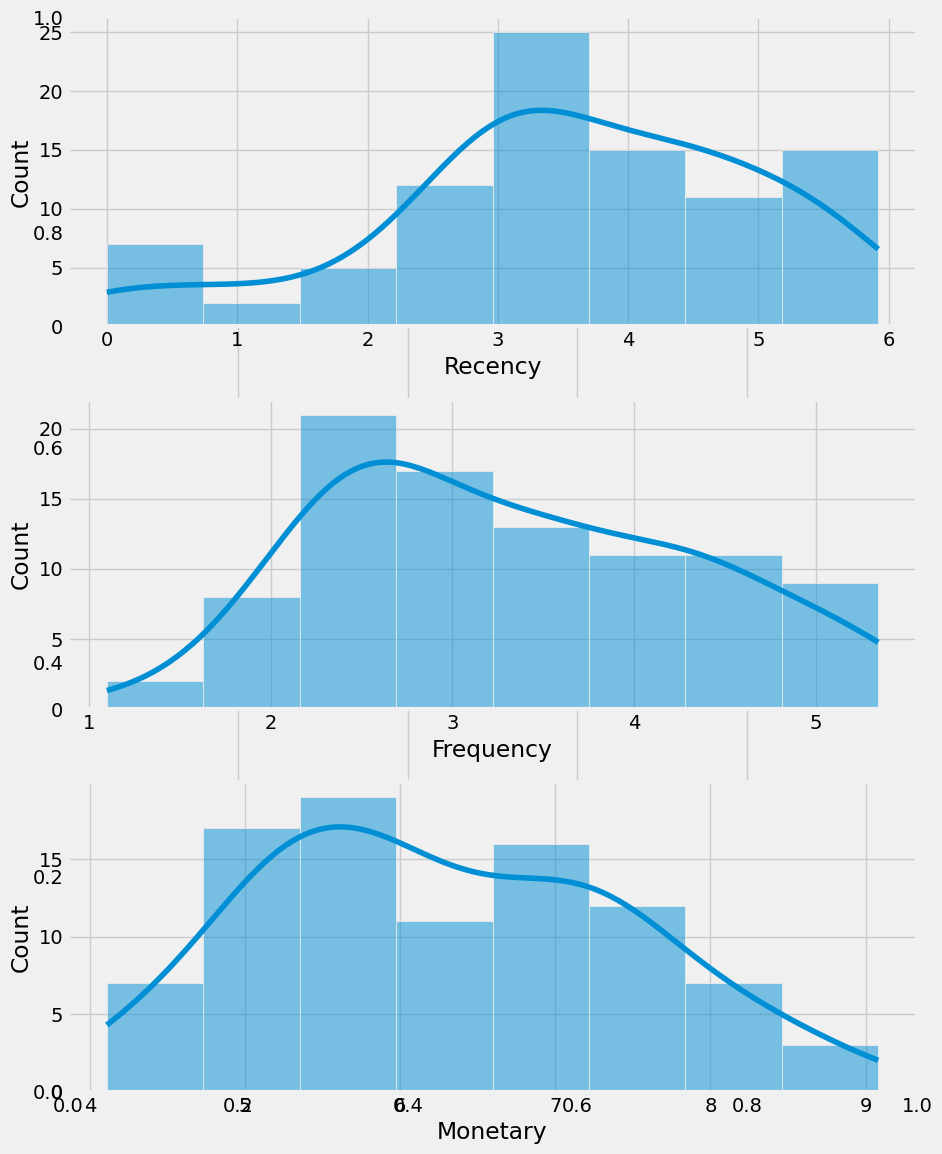

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Add a small constant to avoid log(0)
rfm_log = RFM[['Recency', 'Frequency', 'Monetary']].apply(lambda x: np.log1p(x), axis=1).round(3)

# plot the distribution of RFM values
f, ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.histplot(rfm_log.Recency, kde=True, label='Recency')
plt.subplot(3, 1, 2); sns.histplot(rfm_log.Frequency, kde=True, label='Frequency')
plt.subplot(3, 1, 3); sns.histplot(rfm_log.Monetary, kde=True, label='Monetary')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

Dữ liệu sau khi log transformation sẽ được chuẩn hóa với StandardScaler để đảm bảo rằng các đặc trưng (Recency, Frequency, Monetary) có cùng độ lệch chuẩn và giá trị trung bình 0. Điều này quan trọng đối với thuật toán K-means, vì K-means sử dụng khoảng cách Euclidean để tính toán các cluster, và nếu các đặc trưng có đơn vị khác nhau hoặc có độ lệch chuẩn khác nhau, điều đó sẽ ảnh hưởng đến kết quả phân cụm.

In [32]:
#Normalize the variables with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)

#Store it separately for clustering
rfm_normalized= scaler.transform(rfm_log)

### Choosing no of Clusters

- Tìm số lượng cluster tối ưu (K): Phần này dùng phương pháp "Elbow" để tìm số lượng cluster tối ưu. Phương pháp này dựa trên việc tính toán inertia (độ phân tán bên trong mỗi cluster). Inertia càng thấp thì các điểm trong cluster càng gần với centroid, nhưng nếu chọn số lượng cluster quá nhiều thì inertia sẽ nhỏ hơn rất nhiều, mặc dù đó có thể là quá nhiều cluster không thực sự cần thiết.

- Vẽ biểu đồ Elbow: Biểu đồ này sẽ giúp bạn nhận biết điểm uốn (elbow) trong đường cong, tức là số lượng cluster tại đó inertia bắt đầu giảm chậm lại. Điểm này thường là lựa chọn tối ưu cho số lượng cluster.


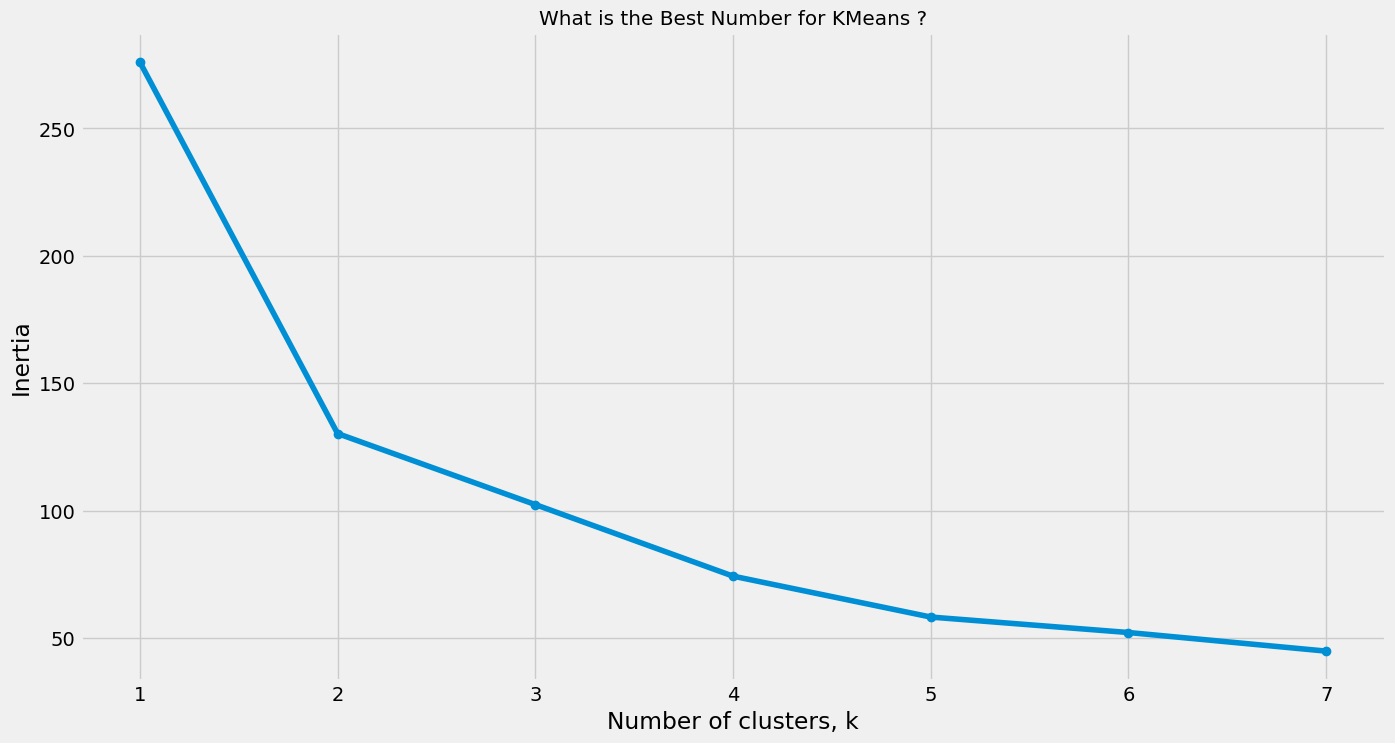

In [33]:
from sklearn.cluster import KMeans
#First : Get the Best KMeans 
ks = range(1,8)
inertias=[]
for k in ks :
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k,random_state=1)
    kc.fit(rfm_normalized)
    inertias.append(kc.inertia_)

    
# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans ?')
plt.show()


# Clustering

In [34]:
kc = KMeans(n_clusters= 2, random_state=1)
kc.fit(rfm_normalized)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

# Cột mới có tên là K_Cluster và chứa nhãn phân cụm từ cluster_labels. 
# Mỗi khách hàng sẽ có một giá trị trong cột này, xác định nhóm phân cụm mà khách hàng đó thuộc về.
rfm_rfm_k3 = rfm_rfm.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_rfm_k3.groupby('K_Cluster').agg({'Recency': 'mean','Frequency': 'mean',
                                        'Monetary': ['mean', 'count'],}).round(0)

Recency Frequency Monetary      
             mean      mean     mean count
K_Cluster                                 
0            -0.0       1.0      1.0    37
1             0.0      -1.0     -1.0    55

Giải thích tại sao ?

### Snake Plots to Understand and Compare Segments

In [35]:
rfm_normalized = pd.DataFrame(rfm_normalized, index=rfm_rfm.index, columns=rfm_rfm.columns)

rfm_normalized['Customer ID'] = RFM['Customer ID']
rfm_normalized['K_Cluster'] = kc.labels_
rfm_normalized['General_Segment'] = RFM['General_Segment']

rfm_normalized.reset_index(drop=True, inplace=True)

# Melt the data into a long format so RFM values and metric names are stored in 1 column each
rfm_melt = pd.melt(rfm_normalized, id_vars=['Customer ID', 'General_Segment', 'K_Cluster'],
                  value_vars=['Recency', 'Frequency', 'Monetary'],
                  var_name='Metric', value_name='Value')

rfm_melt[rfm_melt['Customer ID'] == 12426.0]

,Customer ID,General_Segment,K_Cluster,Metric,Value
0,12426.0,Bronze,1,Recency,1.194625
92,12426.0,Bronze,1,Frequency,-0.755907
184,12426.0,Bronze,1,Monetary,-0.822280


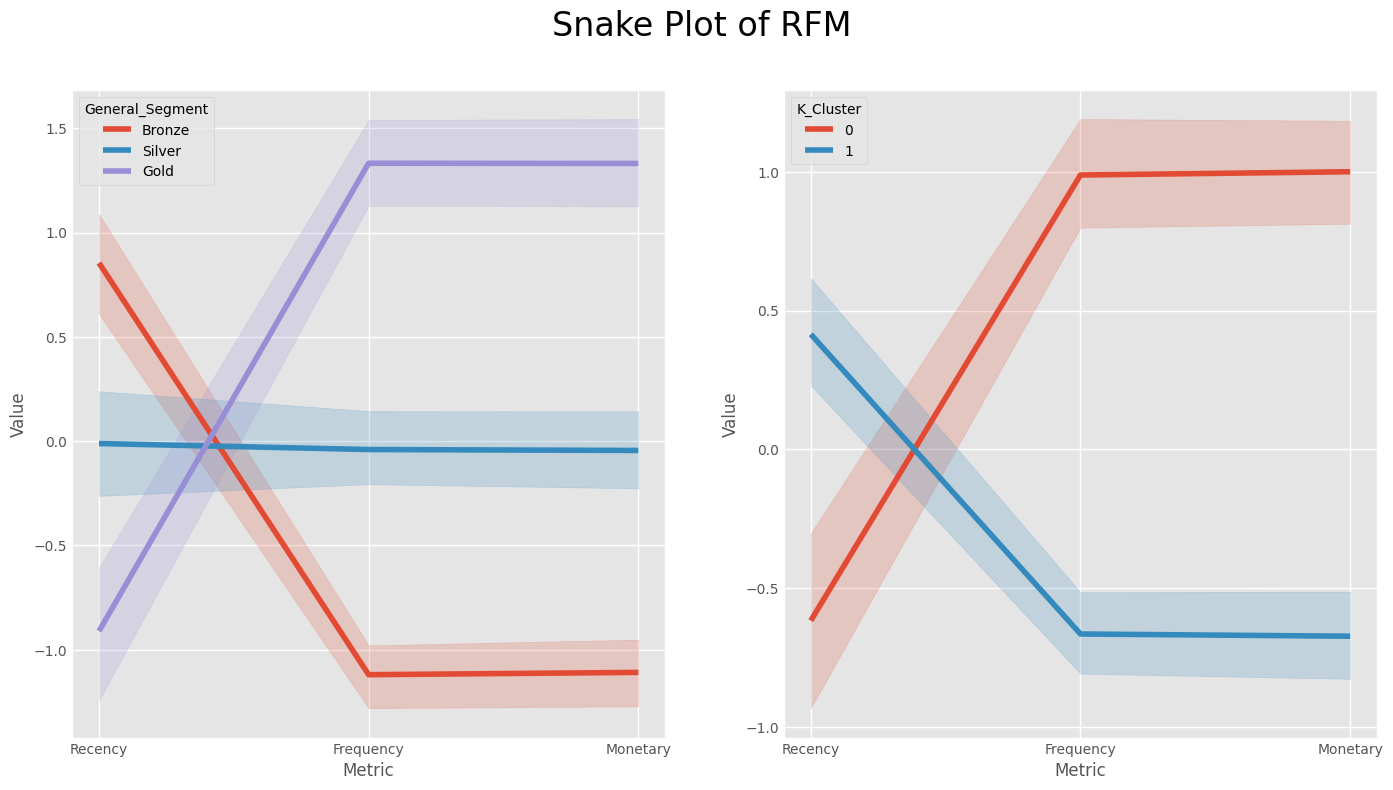

In [36]:
# Snake plot with customer segments
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))
sns.lineplot(x = 'Metric', y = 'Value', hue = 'General_Segment', data = rfm_melt,ax=ax1)

# a snake plot with K-Means
sns.lineplot(x = 'Metric', y = 'Value', hue = 'K_Cluster', data = rfm_melt,ax=ax2)
plt.suptitle("Snake Plot of RFM",fontsize=24) #make title fontsize subtitle 

plt.show()

## NHẬN XÉT BIỂU ĐỒ 1

1. Recency (Sự gần đây của giao dịch):

  + Gold: Giá trị Recency = -1. Điều này cho thấy khách hàng trong nhóm Gold đã mua hàng gần đây hơn so với phần còn lại. Vì giá trị chuẩn hóa âm có nghĩa là các khách hàng trong nhóm này có hành vi mua sắm gần đây hơn so với trung bình của tất cả khách hàng. (vì mua hàng gần đây, giá trị recency nhỏ, nên mang giá trị âm)

  + Silver: Giá trị Recency = 0 cho thấy khách hàng trong nhóm Silver mua hàng cách đây một thời gian tương đối, gần bằng trung bình của tất cả khách hàng.

  + Bronze: Giá trị Recency = 1 cho thấy khách hàng trong nhóm Bronze có hành vi mua sắm lâu hơn, tức là họ ít mua sắm gần đây. Giá trị chuẩn hóa dương có nghĩa là họ mua hàng ít gần đây hơn so với trung bình.

2. Frequency (Tần suất mua hàng):

  + Gold: Giá trị Frequency = 1.2. Khách hàng trong nhóm Gold có tần suất mua sắm cao hơn trung bình. Đây là nhóm khách hàng trung thành và thường xuyên quay lại mua hàng.

  + Silver: Giá trị Frequency = -0.2. Khách hàng trong nhóm Silver có tần suất mua sắm thấp hơn một chút so với trung bình. Họ có thể mua hàng ít thường xuyên hơn so với nhóm Gold nhưng vẫn cao hơn nhóm Bronze.

  + Bronze: Giá trị Frequency = -1.1 cho thấy khách hàng trong nhóm Bronze mua sắm ít thường xuyên, gần như ít hơn so với phần lớn khách hàng. Đây là nhóm khách hàng ít tham gia vào các giao dịch mua hàng.

3. Monetary (Giá trị chi tiêu):

  + Gold: Giá trị Monetary = 1.2 cho thấy khách hàng trong nhóm Gold chi tiêu rất nhiều, cao hơn trung bình. Họ là những khách hàng có giá trị cao và đóng góp nhiều vào doanh thu.

  + Silver: Giá trị Monetary = -0.2 cho thấy khách hàng trong nhóm Silver chi tiêu ít hơn nhóm Gold nhưng vẫn ở mức chấp nhận được.

  + Bronze: Giá trị Monetary = -1.1 cho thấy khách hàng trong nhóm Bronze có mức chi tiêu thấp nhất. Họ chi tiêu ít hơn so với phần lớn khách hàng khác và có thể là những khách hàng ít mang lại doanh thu.

--------------------
* Ứng dụng thực tế:
  - Bạn có thể tập trung vào nhóm Gold với các chiến lược chăm sóc khách hàng tốt nhất, chương trình khách hàng thân thiết, hoặc các ưu đãi đặc biệt để duy trì họ.
  - Với nhóm Silver, bạn có thể thử các chiến lược tái kích hoạt (ví dụ: gửi email hoặc khuyến mãi đặc biệt để kích thích mua sắm lại).
  - Nhóm Bronze cần các chiến lược chuyển đổi hoặc tái kích hoạt như khuyến mãi, quảng cáo, hoặc khảo sát để hiểu lý do vì sao họ ít mua sắm và tìm cách thay đổi hành vi của họ.

## NHẬN XÉT BIỂU ĐỒ 2

1. Cluster 0:
+ Recency = 0.5: Mua gần đây nhưng tần suất và chi tiêu thấp.
+ Frequency = -0.75: Mua sắm không thường xuyên.
+ Monetary = -0.75: Chi tiêu thấp.

Tóm tắt: Đây là nhóm khách hàng ít mua sắm, chi tiêu ít và không thường xuyên giao dịch. Nhóm này có thể là những khách hàng cũ hoặc không quá quan tâm đến sản phẩm/dịch vụ của bạn.

2. Cluster 1:
+ Recency = -0.75: Không mua gần đây.
+ Frequency = 0.75: Tần suất mua sắm cao, họ là khách hàng trung thành.
+ Monetary = 0.75: Chi tiêu cao, nhóm này đóng góp lớn vào doanh thu.

Tóm tắt: Đây là nhóm khách hàng rất trung thành và có chi tiêu cao, mặc dù họ không mua hàng gần đây. Cần áp dụng các chiến lược để tái kích hoạt họ nếu họ đã ngừng mua sắm.

-------------

- Cluster 0 có thể được nhắm đến trong các chiến dịch tái kích hoạt hoặc tăng sự tham gia bằng cách cung cấp các ưu đãi đặc biệt, gửi email thông báo về các sản phẩm mới hoặc giảm giá.

- Cluster 1 có thể được chăm sóc bằng các chiến lược khách hàng trung thành, như các chương trình ưu đãi dành riêng cho khách hàng thân thiết, hoặc gửi quà tặng hoặc giảm giá cho các lần mua sắm tiếp theo để giữ họ quay lại.

# Market Basket Analysis

In [37]:
print(Bronze_seg.info())

<class 'pandas.core.frame.DataFrame'>
Index: 188 entries, 17 to 4130
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Invoice          188 non-null    int64   
 1   StockCode        188 non-null    int64   
 2   Description      188 non-null    object  
 3   Quantity         188 non-null    float64 
 4   InvoiceDate      188 non-null    object  
 5   Price            188 non-null    float64 
 6   Customer ID      188 non-null    float64 
 7   Country          188 non-null    object  
 8   TotalValue       188 non-null    float64 
 9   Recency          188 non-null    int64   
 10  Frequency        188 non-null    int64   
 11  Monetary         188 non-null    float64 
 12  R                188 non-null    category
 13  F                188 non-null    category
 14  M                188 non-null    category
 15  RFM_Segment      188 non-null    object  
 16  RFM_Score        188 non-null    int64   
 17  

### Apriori Algorithm

In [38]:
# pip install efficient-apriori

In [39]:
apriori_data = Bronze_seg[['Invoice', 'Description']]
print(apriori_data.shape)
# Convert the DataFrame to a list of transactions
transactions = apriori_data.groupby(['Invoice'])['Description'].apply(list).tolist()
print(len(transactions))

(188, 2)
36


In [40]:
from efficient_apriori import apriori
import pandas as pd

# Run Apriori algorithm
min_support = 0.001  # Adjust based on dataset
min_confidence = 0.0  # Adjust based on requirements
itemsets, rules = apriori(transactions, min_support=min_support, min_confidence=min_confidence)

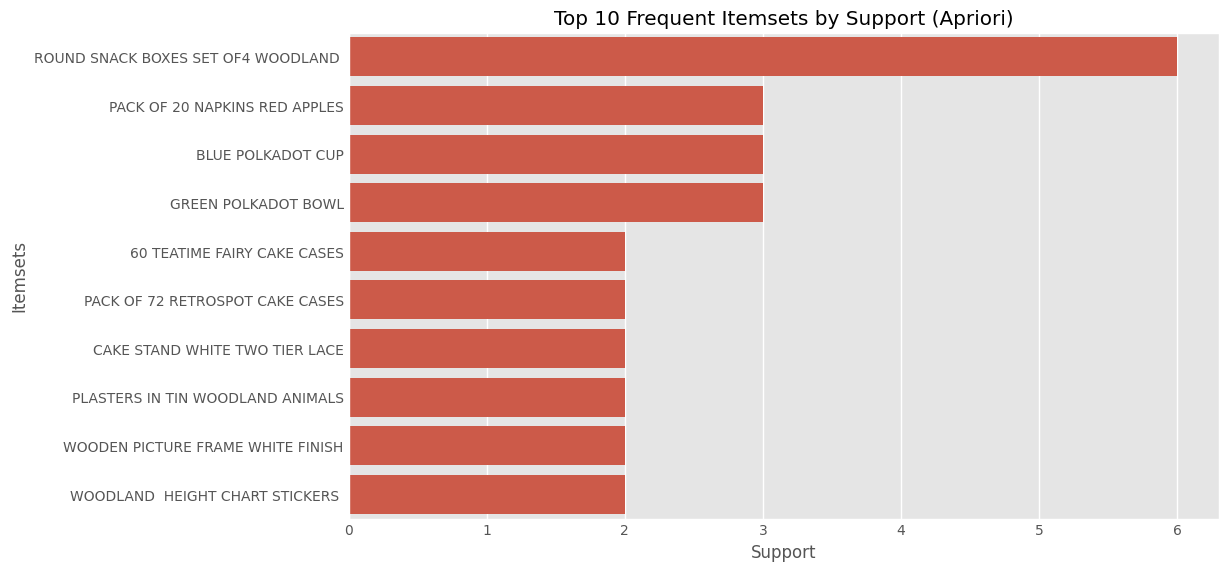

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract itemsets and their support values
itemsets_support = [(itemset, support) for k, v in itemsets.items() for itemset, support in v.items()]

# Sort the itemsets by support in descending order
sorted_itemsets_support = sorted(itemsets_support, key=lambda x: x[1], reverse=True)

# Convert to DataFrame for plotting
frequent_itemsets = pd.DataFrame(sorted_itemsets_support, columns=['itemsets', 'support'])

# Sort frequent itemsets by support
top_itemsets = frequent_itemsets.nlargest(10, 'support')

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='support', y=top_itemsets['itemsets'].apply(lambda x: ', '.join(list(x))), data=top_itemsets)
plt.title('Top 10 Frequent Itemsets by Support (Apriori)')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()

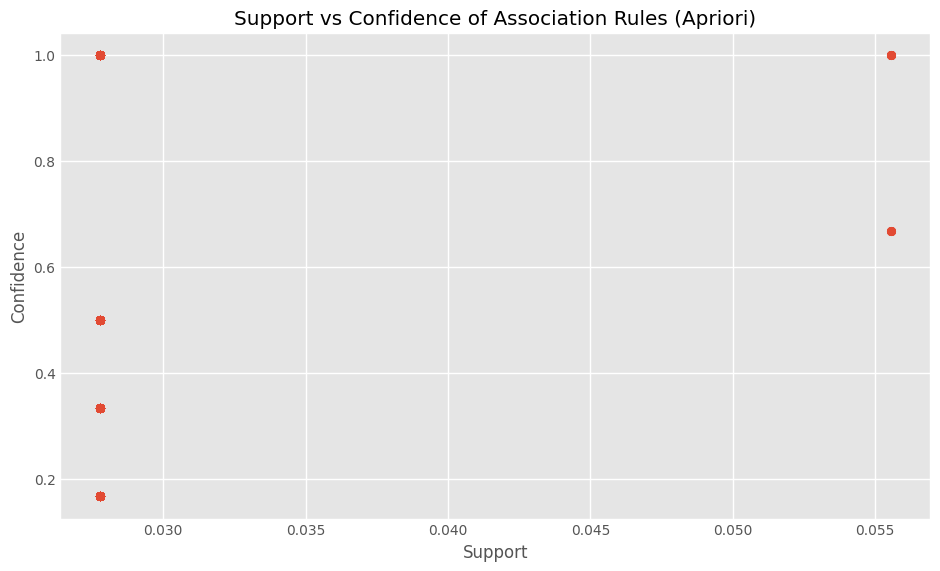

In [42]:
# Extract support and confidence values from rules
support = [rule.support for rule in rules]
confidence = [rule.confidence for rule in rules]

# Scatter plot of support vs confidence
plt.figure(figsize=(10, 6))
plt.scatter(support, confidence, alpha=0.5, marker="o")
plt.title('Support vs Confidence of Association Rules (Apriori)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

In [43]:
print("length of Support :", len(support))
print("length of Confidence :", len(confidence))
print(f"Support range: {min(support)} to {max(support)}")
print(f"Confidence range: {min(confidence)} to {max(confidence)}")

length of Support : 1476184
length of Confidence : 1476184
Support range: 0.027777777777777776 to 0.05555555555555555
Confidence range: 0.16666666666666666 to 1.0


## Item Based Collaborative Filtering for Bronze Segment

### Co-occurence Matrix

In [70]:
# Pivot Table để tạo ma trận sản phẩm - giao dịch
product_matrix = Bronze_seg.pivot_table(
    index='Invoice', 
    columns='Description', 
    values='Quantity', 
    aggfunc='sum', 
    fill_value=0
)

# # Xem trước ma trận
# print(product_matrix.head())


Giá trị tương quan giữa hai sản phẩm cao nghĩa là chúng thường được mua cùng nhau

In [71]:
# Tính toán ma trận tương quan giữa các sản phẩm
corr_matrix = product_matrix.corr(method='pearson')

# # Xem trước ma trận tương quan
# print(corr_matrix.head())


Gợi ý sản phẩm tương tự cho một sản phẩm cụ thể

In [59]:
# Chọn sản phẩm cần tìm sản phẩm tương tự
target_product = "ZINC HEART LATTICE T-LIGHT HOLDER"

# Lọc danh sách sản phẩm tương tự
similar_products = corr_matrix[target_product].dropna().sort_values(ascending=False)

# In top 10 sản phẩm tương tự
print(similar_products.head(10))


Description
SET OF 3 WOODEN TREE DECORATIONS       1.000000
ZINC METAL HEART DECORATION            1.000000
ZINC HEART LATTICE T-LIGHT HOLDER      1.000000
ZINC BOX SIGN HOME                     1.000000
VINTAGE GLASS T-LIGHT HOLDER           1.000000
SET OF 3 WOODEN STOCKING DECORATION    1.000000
ZINC WILLIE WINKIE  CANDLE STICK       0.696932
PACK OF 20 NAPKINS RED APPLES          0.560612
ROUND SNACK BOXES SET OF4 WOODLAND     0.295595
CHILDREN'S APRON DOLLY GIRL           -0.028571
Name: ZINC HEART LATTICE T-LIGHT HOLDER, dtype: float64


Gợi ý sản phẩm cho một khách hàng cụ thể

In [67]:
# Lấy sản phẩm khách hàng đã mua
invoice_id = 536840  # Mã hóa đơn ví dụ   
customer_products = product_matrix.loc[invoice_id]
customer_products = customer_products[customer_products > 0]  # Chỉ lấy sản phẩm đã mua

# Tạo danh sách gợi ý sản phẩm
recommended_products = pd.Series(dtype=float)

for product in customer_products.index:
    print(f"Processing product: {product}")
    sims = corr_matrix[product].dropna()
    sims = sims.map(lambda x: x * customer_products[product])  # Nhân trọng số với số lượng đã mua
    recommended_products = pd.concat([recommended_products, sims])

# Gộp các gợi ý và loại bỏ sản phẩm đã mua
recommended_products = recommended_products.groupby(recommended_products.index).sum()
recommended_products = recommended_products.drop(customer_products.index, errors='ignore')

# Sắp xếp theo mức độ gợi ý
recommended_products.sort_values(ascending=False, inplace=True)
print(recommended_products.head(10))


Processing product: 60 CAKE CASES VINTAGE CHRISTMAS
Processing product: 60 TEATIME FAIRY CAKE CASES
Processing product: CAKE STAND WHITE TWO TIER LACE
Processing product: JAM JAR WITH GREEN LID
Processing product: PACK OF 72 RETROSPOT CAKE CASES
HEART T-LIGHT HOLDER WILLIE WINKIE     14.636337
SET/6 EAU DE NIL BIRD T-LIGHTS         14.636337
PACK OF 60 PINK PAISLEY CAKE CASES     14.636337
CHRISTMAS LIGHTS 10 REINDEER           14.636337
CARD HOLDER GINGHAM HEART              14.636337
WOODLAND  STICKERS                      8.295214
RED TOADSTOOL LED NIGHT LIGHT           8.295214
GREEN POLKADOT BOWL                     5.047142
CAKE PLATE LOVEBIRD WHITE              -1.212576
ROUND SNACK BOXES SET OF4 WOODLAND     -1.358259
dtype: float64
